In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

Our data is split between three .csv files, the main dataset containing transaction data, a secondary dataset linking each client with their age group, and a tertiary dataset mapping each transaction group id to its localization (in Russian). For now, we shall ignore the localisation dataset, as it requires either manual processing, or some form of semantic embedding to be useful. At the moment, simple IDs shall suffice.

In [2]:
transactions = pd.read_csv("transactions_train.csv")
target = pd.read_csv("train_target.csv")

In [3]:
print(transactions.sample(10))
print(target.sample(10))

          client_id  trans_date  small_group  amount_rur
17509295       4784         404            1      95.355
13164786      20119         308            4      16.853
3802728       20120           2            2      97.553
13066904      23216         524            4      17.769
15747947      32318         232            3       2.156
17436727      35615         591           15       2.997
24990332      34758         603           31      19.234
9599079        1910         644           15      30.821
3757441        3289          82            3      25.877
24342817      19853         593           30       7.556
       client_id  bins
6173       29504     2
20153       5382     3
356        44554     0
14158      44665     0
27229      48197     3
4808        3348     0
21886      38023     3
25582       4142     0
16268       5563     0
22978       9692     1


Let's merge the remaining two datasets into one by mapping each client to their respective age group.

In [4]:
target_dict = pd.Series(target.bins.values,index=target.client_id).to_dict()
transactions['bins'] = transactions['client_id'].map(target_dict)

print(transactions.sample(10))

          client_id  trans_date  small_group  amount_rur  bins
9410          43912         381            2     119.971     3
24459211      47463         475            1      25.188     3
8000354        6544         649            4       4.399     3
11500328      13463          91            1       4.082     0
587715         2232         345            1       7.669     0
9159431       47323         185           26     217.363     3
8440891       20062         312            1     195.564     3
730336        12552         671            2      64.679     0
25418864        893         458           15       3.019     2
591294        25684         460            4       3.664     3


Checking for possible NAs. We're good.

In [5]:
print(transactions.isna().sum())

client_id      0
trans_date     0
small_group    0
amount_rur     0
bins           0
dtype: int64


Checking for potential corellations between features. It's better to limit the size of the analyzed sample, since otherwise it might take quite some time.

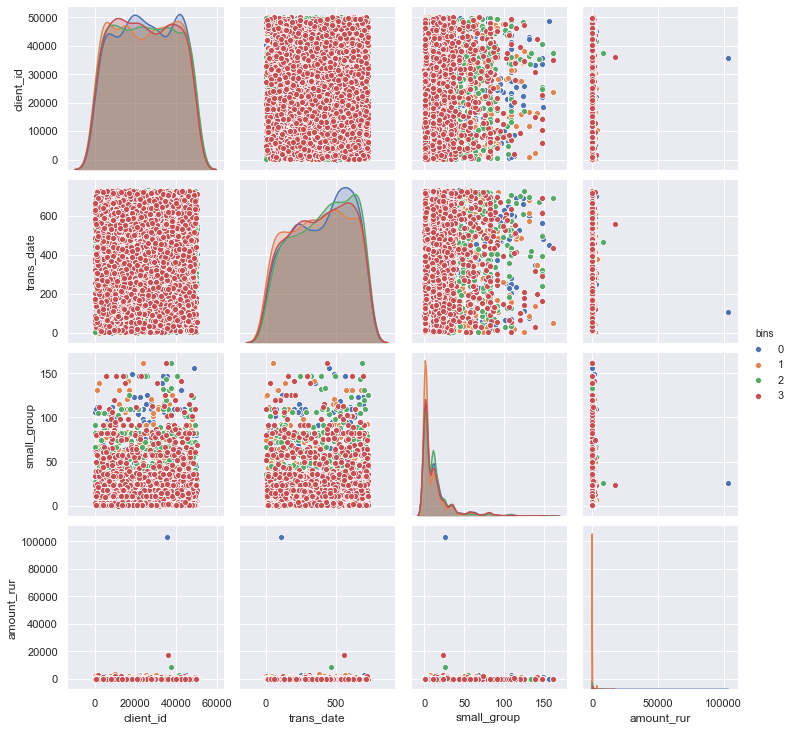

In [6]:
sample = 10000

sns.pairplot(transactions[['client_id','trans_date','small_group', 'amount_rur','bins']].sample(10000), 
             hue= 'bins')

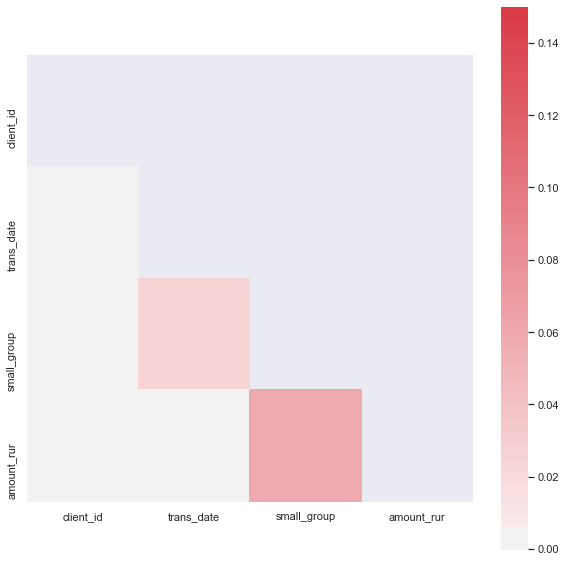

In [7]:
f, ax = plt.subplots(figsize=(10, 10))

corr = transactions[['client_id','trans_date','small_group', 'amount_rur']].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.15, center=0,
            square=True)

As we can see, the features seem to be mostly independent of each other, which is definitely a good thing.

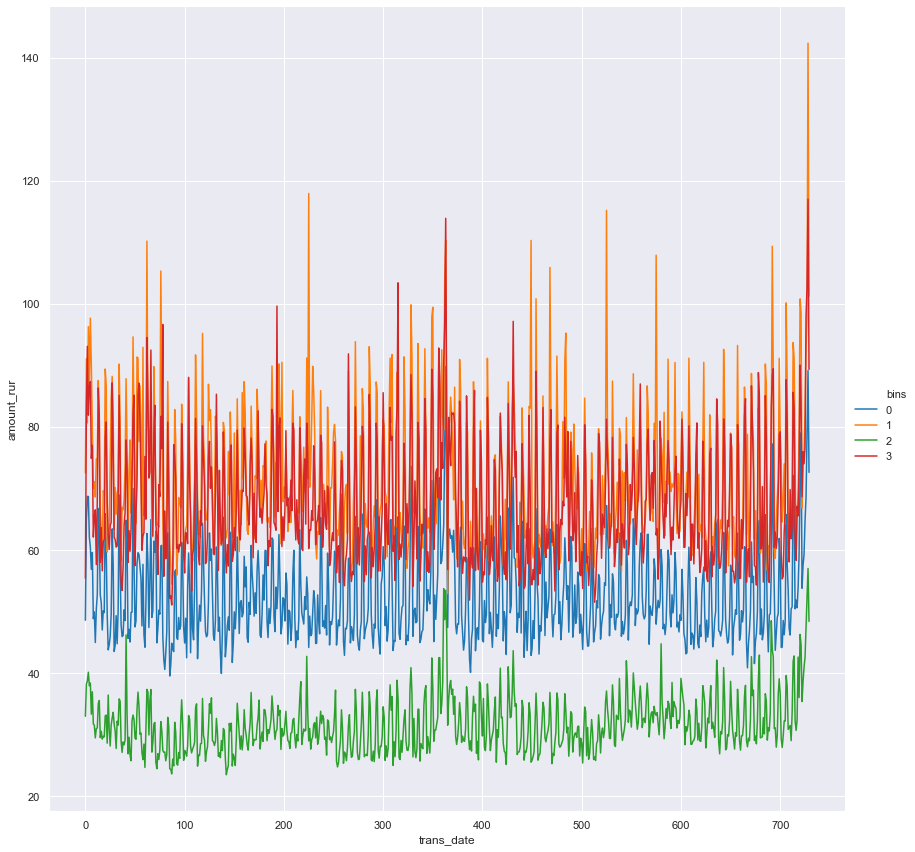

In [8]:
plot_data = transactions.groupby(['trans_date', 'bins']).mean().reset_index()
pl = sns.relplot(x='trans_date', y='amount_rur', hue='bins', data=plot_data, kind="line", height=12, palette='tab10')

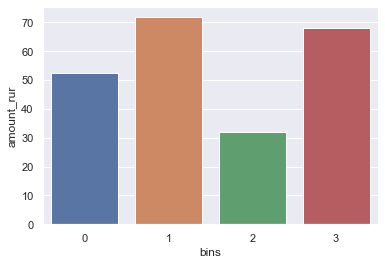

In [9]:
plot_data = transactions.groupby("bins").mean()['amount_rur'].reset_index()
sns.barplot(x='bins', y='amount_rur', data=plot_data)

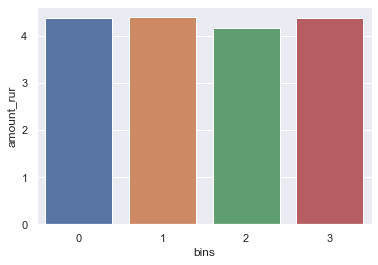

In [23]:
plot_data = transactions[transactions['amount_rur'] < transactions['amount_rur'].quantile(.2)].groupby("bins").mean()['amount_rur'].reset_index()
sns.barplot(x='bins', y='amount_rur', data=plot_data)

Now, let's explore the *small_group* feature. As we can see below, this feature has quite a few unique values that are present for less than 0.01% of entries, some appearing as rare as once or twice in the dataset with millions of entries. 

In [11]:
counts = transactions['small_group'].value_counts(ascending=True)
print(counts[counts < transactions.shape[0] / 10000].count())

93


Let's group the values that together take up less than 1% of all entries into one.

In [12]:
frequencies = transactions['small_group'].value_counts(normalize=True, ascending=True)

print(type(frequencies))

threshold = frequencies[(frequencies.cumsum() > 0.1).idxmax()]
transactions['small_group_filtered'] = transactions['small_group'].mask(transactions['small_group'].map(transactions['small_group'].value_counts(normalize=True)) < threshold, -1)

counts = transactions['small_group_filtered'].value_counts(normalize=True, ascending=True)
print(counts)

<class 'pandas.core.series.Series'>
 8     0.003763
 61    0.003932
 26    0.004015
 32    0.004016
 31    0.004339
 21    0.004595
 35    0.004608
 23    0.004655
 28    0.004879
 37    0.005919
 57    0.005979
 0     0.006267
 16    0.008731
 82    0.009274
 36    0.014081
 34    0.016454
 24    0.017502
 9     0.026062
 25    0.026574
 12    0.029255
 2     0.034344
 18    0.043799
 4     0.045655
 15    0.053953
 3     0.091831
-1     0.097014
 11    0.121089
 1     0.307418
Name: small_group_filtered, dtype: float64


However, a better approach would be to mark values as unpopular not based on the number of transactions, but based on the sums  of currency spent.

In [13]:
normalized_sums = transactions.groupby('small_group').sum()['amount_rur']
normalized_sums /= normalized_sums.sum()
normalized_sorted_sums = normalized_sums.sort_values()

threshold = normalized_sorted_sums[(normalized_sorted_sums.cumsum() > 0.1).idxmax()]

transactions['small_group_filtered'] = transactions['small_group'].mask(transactions['small_group'].map(normalized_sums) < threshold, -1)

normalized_sums = transactions.groupby('small_group_filtered').sum()['amount_rur']
print(normalized_sums)

small_group_filtered
-1      1.466327e+08
 0      7.233369e+06
 1      3.388091e+08
 2      5.226313e+07
 3      4.814014e+07
 4      4.180300e+07
 5      6.527740e+07
 7      9.403218e+06
 8      1.345500e+07
 9      4.440053e+07
 11     6.834635e+07
 12     1.726764e+07
 13     3.249574e+07
 14     2.312462e+07
 15     3.084930e+07
 16     1.354787e+07
 18     5.076317e+07
 20     1.461718e+07
 21     2.697618e+07
 22     9.252313e+06
 23     2.606269e+07
 24     9.138056e+07
 25     1.595414e+07
 26     1.334359e+07
 28     3.695206e+07
 32     1.137025e+07
 34     1.293367e+07
 36     2.882528e+07
 39     2.161356e+07
 43     1.384349e+07
 44     8.678953e+06
 46     2.848812e+07
 50     8.469017e+06
 54     1.115860e+07
 55     1.524599e+07
 57     1.136396e+07
 61     1.002230e+07
 64     1.817777e+07
 72     8.460815e+06
 80     1.777136e+07
 109    1.281200e+07
Name: amount_rur, dtype: float64


     small_group_filtered  bins  amount_rur
0                      -1     0   62.915724
1                      -1     1   98.071440
2                      -1     2   41.979744
3                      -1     3   82.340099
4                       0     0   45.143740
..                    ...   ...         ...
159                    80     3  439.189736
160                   109     0  260.956514
161                   109     1  155.539537
162                   109     2  159.575720
163                   109     3  210.620713

[164 rows x 3 columns]


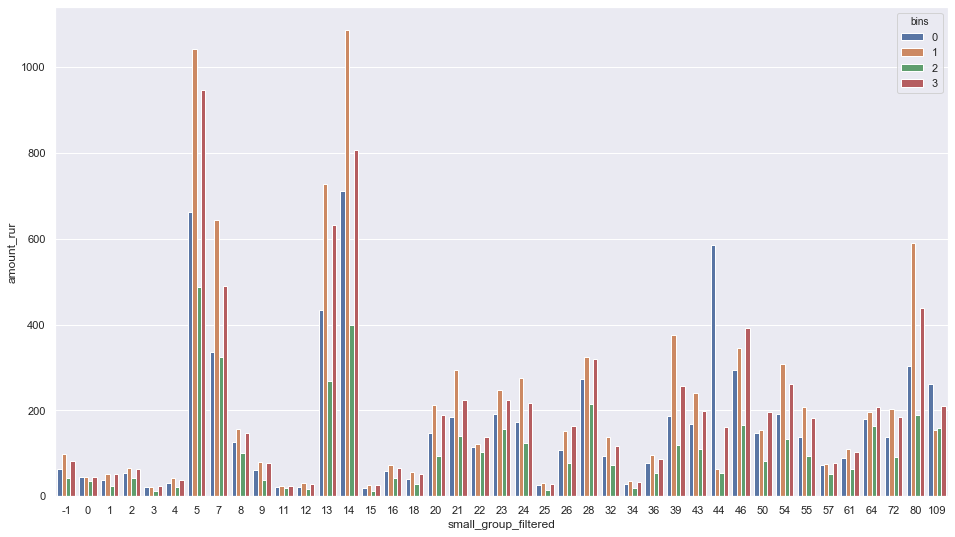

In [14]:
dt

     small_group_filtered  bins    amount_rur
0                      -1     0  3.560816e+07
1                      -1     1  4.292450e+07
2                      -1     2  2.259165e+07
3                      -1     3  4.550838e+07
4                       0     0  1.629012e+06
..                    ...   ...           ...
159                    80     3  5.066054e+06
160                   109     0  5.736346e+06
161                   109     1  1.931490e+06
162                   109     2  2.365870e+06
163                   109     3  2.778298e+06

[164 rows x 3 columns]
       amount_rur  group_deviation
0    3.560816e+07         0.101987
1    4.292450e+07         0.092729
2    2.259165e+07         0.105414
3    4.550838e+07         0.100854
4    1.629012e+06         0.004666
..            ...              ...
159  5.066054e+06         0.011227
160  5.736346e+06         0.016430
161  1.931490e+06         0.004173
162  2.365870e+06         0.011039
163  2.778298e+06         0.006157

[16

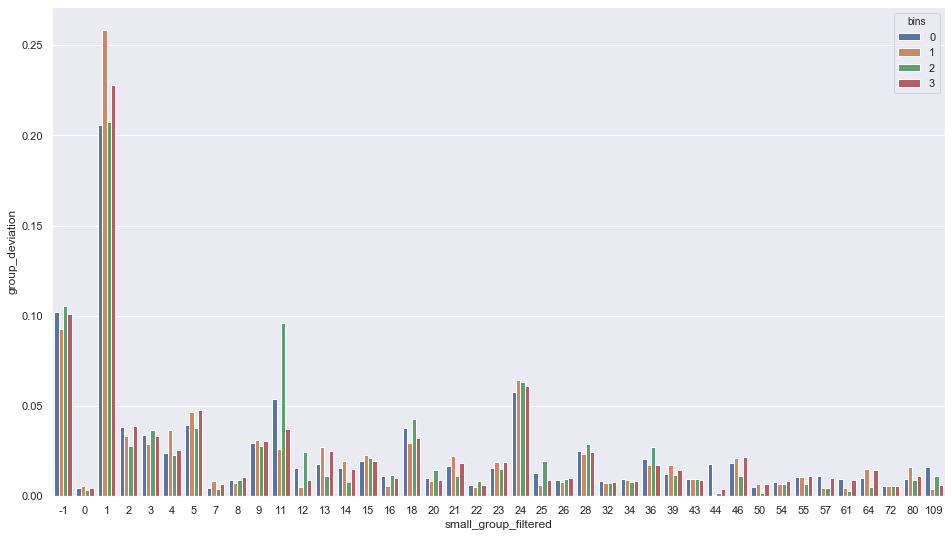

In [15]:
plt.figure(figsize = (16,9))


plot_data = transactions.groupby(['small_group_filtered', 'bins']).sum()['amount_rur'].reset_index()

print(plot_data)

avgs = transactions.groupby('bins').sum().reset_index()
avgs = pd.Series(avgs['amount_rur'].values, index=avgs['bins']).to_dict()


plot_data['group_deviation'] = plot_data['amount_rur']

for bin in plot_data['bins'].unique():
    slice = plot_data.loc[plot_data['bins'] == bin, :]
    plot_data.loc[plot_data['bins'] == bin, 'group_deviation'] = slice['amount_rur'] / avgs[bin]
    
print(plot_data[['amount_rur', 'group_deviation']])

sns.barplot(x='small_group_filtered', y='group_deviation', hue='bins', data=plot_data)

In [17]:
transactions['small_group'] = transactions['small_group_filtered']

transactions = transactions.drop(columns=['small_group_filtered'])

[]

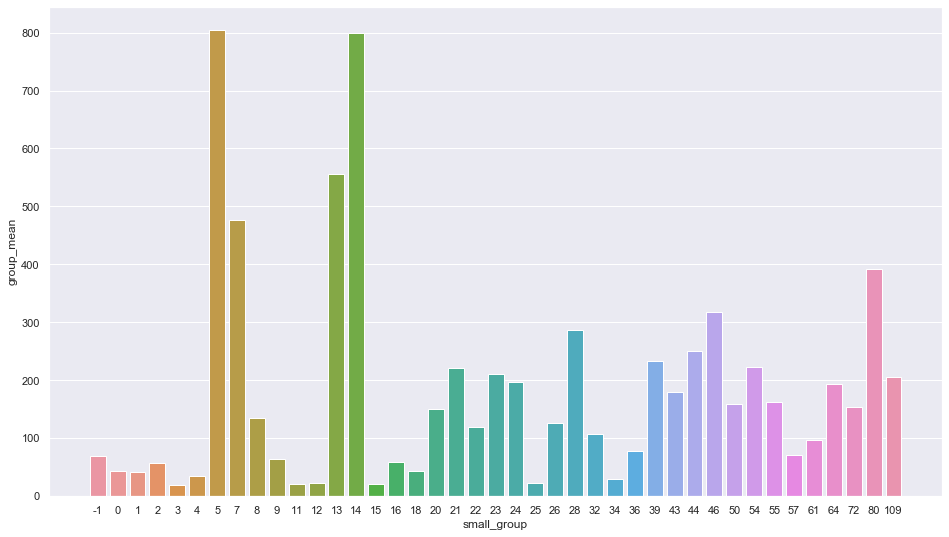

In [19]:
transactions['group_mean'] = transactions['small_group'].map(transactions.groupby('small_group').mean()['amount_rur'])
transactions['group_deviation'] = transactions['amount_rur']/transactions['group_mean']

plot_data = transactions.groupby('small_group').mean().reset_index()
plt.figure(figsize = (16,9))
sns.barplot(x='small_group', y='group_mean', data=plot_data)
plt.plot()
